In [1]:
%pip install emoji
import pandas as pd
import numpy as np
import re
import nltk
import random
nltk.download('punkt')
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords  #stopwords
from nltk.stem import WordNetLemmatizer  
from nltk.tokenize import word_tokenize, sent_tokenize
import emoji
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words=set(stopwords.words('english'))
from gensim.utils import simple_preprocess

# Doc2Vec model
import gensim
from gensim.parsing.preprocessing import preprocess_documents
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import defaultdict


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khauv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khauv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khauv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\khauv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('question_responce.csv')
df.head


<bound method NDFrame.head of       Unnamed: 0                                           responce  \
0            603  @115904 We'll be sure to pass along your kind ...   
1            605  @115904 Our apologies for the delay in respond...   
2            608  @115905 Aww, that's definitely a future pilot ...   
3            612          @115906 We're sorry for your frustration.   
4            618  @115909 We're glad you got to kick back and en...   
...          ...                                                ...   
1847      201947  @172376 We know staying connected is important...   
1848      203418  @172677 We've capped our fares for nonstop fli...   
1849      203504  @143005 Please give our Baggage team a call at...   
1850      203506  @143005 Our apologies for the hold. Our Centra...   
1851      203633  @172730 We're providing waivers for St Croix, ...   

                                               question  
0     @AmericanAir Erica on the lax team is amazing ...  
1

# Preprocessing

In [3]:
def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)
    
def preprocess(string):
    emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth      
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""
    string = re.sub(r'\s+', ' ', string)
    string = re.sub(r'\[[0-9]*\]', '', string)
    string = re.sub(r'(@([A-Za-z0-9`~!@#$%^&*()_|+\-=?;:\'",.<>\{\}\[\]\\\/]{2,32}))', '', string) # remove tags
    string = re.sub(r'\d+', '', string) # remove numbers
    string = re.sub(r'\#+', '', string) # remove hashtags
    string = re.sub(r'http\S+', '', string) # remove urls
    string = re.sub(emoticon_string,'', string)# remove emojis
    string = simple_preprocess(string,deacc=True) #tokenizing, lowercasing, removing accents

    lemma_function = WordNetLemmatizer()
    lemma = [lemma_function.lemmatize(w) for w in string if w not in stop_words and len(w) > 3]
    return lemma

text_data = [] 
text_data = df['question'].apply(preprocess) #preprocessing

print(text_data)

0                     [erica, team, amazing, give, raise]
1       [could, someone, team, available, guide, gate,...
2       [tennyson, american, airline, pilot, trunkortr...
3       [right, earned, also, pas, spouse, need, chang...
4       [thank, playing, thisisus, great, flight, atte...
                              ...                        
1847    [nailed, transatlantic, wifi, service, able, j...
1848                             [average, price, ticket]
1849    [really, annoyed, month, since, damaged, claim...
1850    [terrible, service, wait, age, trying, call, n...
1851    [charge, patron, change, flight, every, time, ...
Name: question, Length: 1852, dtype: object


# Intents / Topic Modelling

In [4]:
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools


In [5]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]


import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

### LdaModel

In [6]:
import gensim
NUM_TOPICS = 100
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(7, '0.033*"flight" + 0.020*"wifi" + 0.013*"look" + 0.013*"good"')
(53, '0.025*"password" + 0.019*"special" + 0.019*"character" + 0.019*"flight"')
(57, '0.068*"flight" + 0.022*"cool" + 0.016*"pilot" + 0.016*"first"')
(71, '0.045*"flight" + 0.020*"need" + 0.015*"make" + 0.010*"switch"')
(42, '0.053*"flight" + 0.018*"stop" + 0.014*"part" + 0.014*"american"')
(18, '0.036*"flight" + 0.017*"home" + 0.017*"customer" + 0.016*"thanks"')
(47, '0.026*"lost" + 0.026*"flight" + 0.026*"plane" + 0.017*"baggage"')
(31, '0.017*"luggage" + 0.017*"flight" + 0.011*"upgraded" + 0.011*"customer"')
(4, '0.048*"flight" + 0.015*"thanks" + 0.015*"gate" + 0.013*"great"')
(84, '0.032*"flight" + 0.015*"change" + 0.015*"never" + 0.010*"hour"')
(54, '0.026*"flight" + 0.016*"without" + 0.016*"need" + 0.013*"delay"')
(22, '0.058*"flight" + 0.029*"seat" + 0.019*"like" + 0.018*"time"')
(79, '0.031*"flight" + 0.022*"time" + 0.022*"gate" + 0.013*"service"')
(68, '0.031*"flight" + 0.029*"gate" + 0.017*"thank" + 0.017*"cha

La niveau de cohérence est assez pas. Passons au LdaMallet qui doit donner de meilleurs résultats.

### LdaMallet

In [7]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:/Users/khauv/Documents/Github/Rule-based-chatbot/mallet-2.0.8/'
mallet_path = 'C:/Users/khauv/Documents/Github/Rule-based-chatbot/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)

# Show Topics
print(ldamallet.show_topics(formatted=False))


[(8, [('delay', 0.11093247588424437), ('hour', 0.0819935691318328), ('issue', 0.07877813504823152), ('problem', 0.04823151125401929), ('told', 0.03536977491961415), ('missed', 0.03054662379421222), ('family', 0.028938906752411574), ('maintenance', 0.02572347266881029), ('ground', 0.01929260450160772), ('international', 0.017684887459807074)]), (16, [('upgrade', 0.08452950558213716), ('love', 0.049441786283891544), ('work', 0.0430622009569378), ('food', 0.03987240829346093), ('platinum', 0.028708133971291867), ('experience', 0.023923444976076555), ('amazing', 0.023923444976076555), ('terminal', 0.02073365231259968), ('awesome', 0.02073365231259968), ('landing', 0.017543859649122806)]), (7, [('flight', 0.27436281859070466), ('delayed', 0.095952023988006), ('hour', 0.07496251874062969), ('connection', 0.034482758620689655), ('miss', 0.029985007496251874), ('money', 0.025487256371814093), ('reason', 0.022488755622188907), ('december', 0.01649175412293853), ('scheduled', 0.01649175412293853

- Fonction pour evaluer le niveau de cohérence du model

In [8]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5792077373285466


- Fonction pour évaluer le niveau de cohérence du model dans un interval donnée de nombres de topics

In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

- Graphique entre la cohérence et le nombre de topics

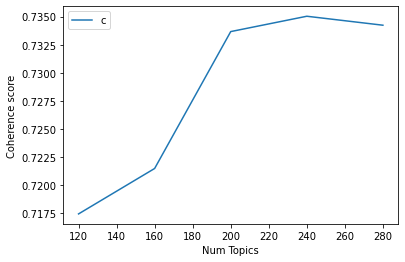

In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text_data, start=120, limit=320, step=40)
import matplotlib.pyplot as plt
# Show graph
limit=320; start=120; step=40;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

On choisit le nombre de topics là où la courbe commence à stabiliser, ici 240.

- Les 240 topics du model que l'on a choisit

In [11]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(181, '0.323*"card" + 0.169*"stop" + 0.154*"credit" + 0.015*"website" + 0.015*"elite" + 0.015*"town" + 0.015*"back" + 0.015*"flight" + 0.015*"worried" + 0.015*"updated"'), (38, '0.396*"time" + 0.042*"exceptional" + 0.042*"apparently" + 0.042*"state" + 0.042*"reach" + 0.021*"takeoff" + 0.021*"exit" + 0.021*"salida" + 0.021*"people" + 0.021*"return"'), (14, '0.396*"hour" + 0.094*"water" + 0.075*"carrier" + 0.057*"checked" + 0.038*"yesterday" + 0.019*"penalty" + 0.019*"prouder" + 0.019*"drop" + 0.019*"minute" + 0.019*"middle"'), (198, '0.171*"airport" + 0.129*"seat" + 0.071*"board" + 0.071*"plane" + 0.057*"left" + 0.043*"malfunction" + 0.029*"mechanical" + 0.029*"leaf" + 0.029*"waiting" + 0.014*"assignment"'), (173, '0.213*"time" + 0.128*"missed" + 0.085*"miami" + 0.085*"receive" + 0.064*"place" + 0.043*"disappointed" + 0.043*"girlfriend" + 0.043*"waiting" + 0.021*"rockstars" + 0.021*"description"'), (159, '0.421*"check" + 0.211*"bag" + 0.053*"forced" + 0.053*"full" + 0.032*"destination"

- Attribution des topics pour tous les messages du dataset dans un même dataframe

In [12]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=text_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.question.values.tolist())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,226.0,0.0159,"give, gate, back, announced, miss, wing, fille...",@AmericanAir Erica on the lax team is amazing ...
1,1,232.0,0.0121,"make, mile, flight, comfortable, made, asap, b...",@AmericanAir Could you have someone on your la...
2,2,235.0,0.0381,"airline, american, week, contact, reconocerlo,...",Ben Tennyson and an American Airlines pilot. 🎃...
3,3,1.0,0.0139,"back, flyer, frequent, program, trip, mile, bu...","@AmericanAir Right, but I earned those. I also..."
4,4,192.0,0.0227,"back, attendant, voucher, wanted, checked, mai...","Thank you, @AmericanAir for playing #ThisIsUs ..."
5,5,74.0,0.0600,"wifi, making, delta, dont, loyal, easy, teach,...",@AmericanAir's wifi makes Amtrak's wifi look p...
6,6,115.0,0.0582,"club, admiral, team, claim, guy, tonight, clas...",Wonderful club! @americanair (@ American Airli...
7,7,65.0,0.0251,"attendant, visit, finally, shit, changed, peop...","@AmericanAir already did...changed browsers, d..."
8,8,69.0,0.0121,"hold, return, family, enjoy, browser, reservat...",@AmericanAir ........still....on....hold.....t...
9,9,34.0,0.0156,"ticket, delayed, worst, stop, expectation, buy...",@AmericanAir well now i am told the ticket cos...


- Ajout de la colonne 'responce' dans le dataframe réalisé precedemment contenant les questions et leur topic

In [13]:
complete_df= df_dominant_topic.join(df['responce'], lsuffix='_database', rsuffix='_input')
complete_df.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,responce
0,0,226.0,0.0159,"give, gate, back, announced, miss, wing, fille...",@AmericanAir Erica on the lax team is amazing ...,@115904 We'll be sure to pass along your kind ...
1,1,232.0,0.0121,"make, mile, flight, comfortable, made, asap, b...",@AmericanAir Could you have someone on your la...,@115904 Our apologies for the delay in respond...
2,2,235.0,0.0381,"airline, american, week, contact, reconocerlo,...",Ben Tennyson and an American Airlines pilot. 🎃...,"@115905 Aww, that's definitely a future pilot ..."
3,3,1.0,0.0139,"back, flyer, frequent, program, trip, mile, bu...","@AmericanAir Right, but I earned those. I also...",@115906 We're sorry for your frustration.
4,4,192.0,0.0227,"back, attendant, voucher, wanted, checked, mai...","Thank you, @AmericanAir for playing #ThisIsUs ...",@115909 We're glad you got to kick back and en...


# Process

- Input de l'utilisateur et son topic (A faire)

In [14]:
userinput=preprocess("I have passed an agreable moment with you! Thank you!")
dictionaryInput = corpora.Dictionary([userinput])
corpusInput = [dictionary.doc2bow(userinput)]

df_topic_test = format_topics_sentences(ldamodel=optimal_model, corpus=corpusInput, texts="@AmericanAir Erica on the lax team is amazing give her a raise ty")

# Format
df_dominant_topic_test = df_topic_test.reset_index()
df_dominant_topic_test.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic_test.head()


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,142.0,0.0147,"flight, captain, find, send, price, passed, wi...",@AmericanAir Erica on the lax team is amazing ...


- Filtrage du dataframe selon un topic

In [15]:
oui = complete_df[complete_df['Dominant_Topic']==176.0]
oui.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,responce
546,546,176.0,0.0139,"miami, flying, changing, issue, seat, reward, ...",Does anyone know how we can check to see if ou...,@136438 We're working on this issue and expect...
1843,1843,176.0,0.0162,"miami, flying, changing, issue, seat, reward, ...",Without a doubt @AmericanAir has the worst rew...,"@172158 We strive for a great rewards program,..."


In [22]:
def clean_text(text):    
    emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth      
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""
    
    # Remove stopwords 
    answers  = []
    for i in tweet_data.responce:
        i = give_emoji_free_text(i).lower()
        answers.append(re.sub(r'\s+', ' ',
                            re.sub(r'\[[0-9]*\]', ' ',
                            re.sub(r'(@([A-Za-z0-9`~!@#$%^&*()_|+\-=?;:\'",.<>\{\}\[\]\\\/]{2,32}))', '', # remove tags
                            re.sub(r'\d+', ' ', # remove numbers
                            re.sub(r'\#+', ' ', # remove hashtags
                            re.sub(r'http\S+', ' ', # remove urls
                            re.sub(emoticon_string,'', # remove emojis
                            re.sub(r'[\.\?\!\,\:\;\"]', '', i) # remove punctuation
                                  ))))))))
    # Lemmatization and tokenization
    sentences = []
    le = WordNetLemmatizer()
    for i in answers:
        word_tokens = word_tokenize(i)
        lemmas = [ le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w) > 3 ]
        cleaned_text=" ".join(lemmas)
        sentences.append(cleaned_text)
    

    
    return sentences

In [23]:
tweet_data = oui[["Text","responce"]]
responce_data = clean_text(tweet_data.responce) #preprocessing

print(responce_data)

['working issue expect avoid cancellation', 'strive great reward program hear liking offer']


<ipython-input-3-eb7aabf9e3c4>:2: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.get_emoji_regexp().sub(r'', text)


In [24]:
# Doc2Vec model
import gensim
from gensim.parsing.preprocessing import preprocess_documents
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [25]:
processed_corpus = preprocess_documents(responce_data)
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(responce_data)]

In [26]:
tagged_data

[TaggedDocument(words='working issue expect avoid cancellation', tags=[0]),
 TaggedDocument(words='strive great reward program hear liking offer', tags=[1])]

In [28]:
model = Doc2Vec(tagged_data, 
                vector_size=200, 
                epochs=100, 
                hs=1, # use of hierachical softmax
                min_count=1, 
                window=2, # Max distance
                dm =0) # PV-Bag of words used
  
#model.build_vocab(tagged_data)
train_corpus = [taggeddoc for taggeddoc_list in tagged_data for taggeddoc in taggeddoc_list]

for epoch in range(model.epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=2,
                epochs=100)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [39]:
def response_sentences(most_similar, cleaned_sentences):
    answer = []
    for label,index in [('MOST', 0)]:#, ('SECOND-MOST', 1), ('MEDIAN', len(most_similar)//2), ('LEAST', len(most_similar) - 1)]:
        answer.append(cleaned_sentences[int(most_similar[index][0])])
        #print(u'%s %s: %s\n' % (label, most_similar[index][1], cleaned_sentences[int(most_similar[index][0])]))
    return answer

In [41]:
def input_intent(user_query):
    userinput=preprocess(user_query)
    dictionaryInput = corpora.Dictionary([userinput])
    corpusInput = [dictionary.doc2bow(userinput)]

    df_topic_test = format_topics_sentences(ldamodel=optimal_model, corpus=corpusInput, texts="@AmericanAir Erica on the lax team is amazing give her a raise ty")

    # Format
    df_dominant_topic_test = df_topic_test.reset_index()
    df_dominant_topic_test.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

    topic_input_value = df_dominant_topic_test['Dominant_Topic'].iloc[0]

    df_topic_input = complete_df[complete_df['Dominant_Topic']==topic_input_value]

    tweet_data = df_topic_input[["Text","responce"]]
    cleaned_sentences = clean_text(tweet_data.responce)
    processed_corpus = preprocess_documents(cleaned_sentences)
    tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(cleaned_sentences)]

    model = Doc2Vec(tagged_data, 
                vector_size=200, 
                epochs=100, 
                hs=1, # use of hierachical softmax
                min_count=1, 
                window=2, # Max distance
                dm =0) # PV-Bag of words used
  
    #model.build_vocab(tagged_data)
    train_corpus = [taggeddoc for taggeddoc_list in tagged_data for taggeddoc in taggeddoc_list]

    for epoch in range(model.epochs):
        model.train(tagged_data,
                total_examples=2,
                epochs=100)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

    model.save("d2v.model")

    return cleaned_sentences

In [42]:
def response(user_query):
    # Using TFID Add the query to the answers list and vectorize it, then measure the cosine similarity between query and answers
    """cleaned_sentences.append(user_query)
    vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=1000)
    sentences_vectors = vectorizer.fit_transform(cleaned_sentences)
    
    similar_vector_values = cosine_similarity(sentences_vectors[-1], sentences_vectors)
    similar_sentence_number = similar_vector_values.argsort()[0][-2]
    
    matched_vector = similar_vector_values.flatten()
    matched_vector.sort()
    matched_vector = matched_vector[-2]

    if matched_vector == 0: # no vector matching
        return "I didn't understand, can you reformulate please ?"
    else: 
        return cleaned_sentences[similar_sentence_number]"""
    cleaned_sentences = input_intent(user_query)
    
    # Using doc2vec
    model= Doc2Vec.load("d2v.model")
    
    # vector of a document which is not in training data
    cleaned = word_tokenize(user_query.lower())
    v1 = model.infer_vector(cleaned)
    #print("V1_infer", v1)

    # most similar sentences using tags
    similar_doc = model.docvecs.most_similar([v1])
    return response_sentences(similar_doc, cleaned_sentences)

In [43]:
# Greetings
greetings = ('hey', 'hello', 'whats up', 'good morning', 'good evening', 'morning', 'evening', 'hello there', 'hey there')
greeting_responses = ["hey", "hey hows you?", "*nods*", "hello, how you doing", "hello", "Welcome, I am good and you"]
# Goodbye
goodbye = ('bye', 'good bye', 'take care')
goodbye_responses = ['See you next time !', 'Bye see you next time ! Hope I was helpful :p']
# Apology
apology = ['sorry', 'I apologize', 'disapointed']
# Thanks
thanks =('thank you', 'thanks', 'grateful', 'pleased')
thanks_responses = ['Always a pleasure to help you !', 'You\'re welcome !', 'No problem ! :)']
def greeting_response(query):
    for token in query.split():
        if token.lower() in greetings:
            return random.choice(greeting_responses)
        if token.lower() in thanks:
            return random.choice(thanks_responses)
        if token.lower() in goodbye:
            return random.choice(goodbye_responses)
            break

In [45]:
print("Hello, I am the bot assistant of American Air, here to answer to your questions. Please ask me anything :))")

while(True):
    query = input().lower()
    if query not in goodbye:
        if query in greetings or query in thanks or query in goodbye:
            print(greeting_response(query))
        else:
            print("Twitter Chatbot: ", end="")
            print(response(query))
            #cleaned_sentences.remove(query)
    else:
        print()
        break

Hello, I am the bot assistant of American Air, here to answer to your questions. Please ask me anything :))
hey
Twitter Chatbot: 

<ipython-input-3-eb7aabf9e3c4>:2: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.get_emoji_regexp().sub(r'', text)


['strive great reward program hear liking offer']
Twitter Chatbot: 

<ipython-input-3-eb7aabf9e3c4>:2: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.get_emoji_regexp().sub(r'', text)


KeyboardInterrupt: 